# Analysis: Impact of Chatbot Usage on Student Performance

This notebook analyzes whether daily chatbot usage (`message_count`) influences students' performance scores using a Linear Mixed-Effects Model.

We use two datasets:
- `performances.csv`: test outcomes
- `user_days.csv`: daily chatbot activity and learning behavior

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import ast

# Load data
performances = pd.read_csv("data/features/performances.csv")
user_days = pd.read_csv("data/features/user_days.csv")

# Convert dates
performances["date"] = pd.to_datetime(performances["date"])
user_days["date"] = pd.to_datetime(user_days["date"])

In [2]:
performances.head()

,user_id,domain,test_id,course,date,time,percentage,performance
0,1,essay,eroerterung,3301,2024-11-29,2024-11-29 23:52:33,63.000000,-7.090000
1,1,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:24:30,55.294118,-8.075882
2,4,essay,eroerterung,3301,2024-11-21,2024-11-21 17:23:46,66.000000,-4.090000
3,4,essay,erzaehlung,3301,2024-11-07,2024-11-07 16:13:25,71.000000,3.390000
4,5,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:23:58,44.705882,-18.664118


In [3]:
user_days.head()

,user_id,date,type,user_day,number_of_activities,domain,activity_type,time_in_minutes,message_count
0,1,2024-10-26,both,1.0,2.0,essay,lesson,0.0,NaN
1,1,2024-10-30,activity,2.0,0.0,NaN,NaN,NaN,NaN
2,1,2024-10-31,activity,3.0,1.0,text,lesson,0.0,NaN
3,1,2024-11-01,activity,4.0,6.0,essay,lesson,0.0,NaN
4,1,2024-11-01,activity,4.0,6.0,text,lesson,0.0,NaN


### Mapping 

In [4]:
mapping = pd.read_csv("data/original/mapping.csv")
gymitrainer = pd.read_csv("data/original/gymitrainer.csv")

print(mapping.shape[0])
mapping.head()

8408


,Unnamed: 0,user_id,delta,confidence,id
0,0,282,1039460,0.200156,c40e9e5f-39fa-415d-b806-69846ea659b3
1,1,282,1038323,0.200156,78a59adc-96b4-44c7-aad6-f669c944794e
2,2,282,966940,0.200168,419631b2-5dbb-4b1d-b323-b3c758c4933d
3,3,282,966558,0.200168,c2b07040-8023-4c68-bf45-0f7ab0a33b38
4,4,282,965864,0.200168,9d9501ba-732d-49e5-b40c-ba261a0db18f


In [5]:
print('nb of interactions :',gymitrainer.shape[0])
gymitrainer.head()

nb of interactions : 8245


,Unnamed: 0,id,chat_profile,tag,message_count,startTime,endTime,content
0,0,8d8b7ed3-393a-4fff-a3de-3cd515399efa,NaN,NaN,0,1741330528,1741330535,"['Hallo! Ich bin Gymitrainer, dein Tutor für d..."
1,1,f27276e8-eca8-419e-8f13-1677aac6c5b8,NaN,NaN,0,1741330363,1741330368,"['Hallo! Ich bin Gymitrainer, dein Tutor für d..."
2,2,b870f1ce-6fd3-4353-96c3-7fb44c9add19,NaN,NaN,0,1741330310,1741330326,"['Hallo! Ich bin Gymitrainer, dein Tutor für d..."
3,3,873d766b-baf9-4c88-a27b-9f842df763d8,NaN,NaN,0,1741330270,1741330294,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor..."
4,4,2c470a15-7dc4-4b83-be81-61501b325d0d,NaN,NaN,0,1741123788,1741123799,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor..."


In [6]:
gymitrainer_with_users = pd.merge(gymitrainer,mapping,  on='id',how='left')
gymitrainer_with_users = gymitrainer_with_users[gymitrainer_with_users['message_count'] > 0]

print('nb of chats :' , gymitrainer_with_users.shape[0])
print('nb of chats with confidence > 0.4:' , gymitrainer_with_users[gymitrainer_with_users['confidence']>0.4].shape[0])
print('nb of chats with confidence > 0.69:' , gymitrainer_with_users[gymitrainer_with_users['confidence']>0.69].shape[0])

nb of chats : 7707
nb of chats with confidence > 0.4: 3500
nb of chats with confidence > 0.69: 1612


In [7]:
print('The median value for confidence :', gymitrainer_with_users['confidence'].median().round(1))

The median value for confidence : 0.4


In [8]:
### For the following analysis we will use > 0.4 confidence data :

gymitrainer_with_users = gymitrainer_with_users[gymitrainer_with_users['confidence'] > 0.4][['user_id', 'chat_profile', 'tag', 'startTime', 'endTime', 'content', 'message_count', 'confidence']]


gymitrainer_with_users = gymitrainer_with_users.copy()
gymitrainer_with_users["startTime"] = pd.to_datetime(gymitrainer_with_users["startTime"], unit="s")
gymitrainer_with_users["endTime"] = pd.to_datetime(gymitrainer_with_users["endTime"], unit="s")

gymitrainer_with_users.head()

,user_id,chat_profile,tag,startTime,endTime,content,message_count,confidence
7,246,NaN,NaN,2025-03-04 12:55:19,2025-03-04 12:58:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",3,0.961883
12,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:31:08,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514
13,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:29:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",2,0.952514
14,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:26:38,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514
15,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:17:56,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514


In [9]:
gymitrainer_with_users.to_csv('data/cleaned/gymitrainer_40percent.csv')

gymitrainer_with_users.head()

,user_id,chat_profile,tag,startTime,endTime,content,message_count,confidence
7,246,NaN,NaN,2025-03-04 12:55:19,2025-03-04 12:58:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",3,0.961883
12,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:31:08,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514
13,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:29:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",2,0.952514
14,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:26:38,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514
15,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:17:56,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514


In [10]:
#gymitrainer_with_users = pd.read_csv('data/cleaned/gymitrainer_40percent.csv')

In [11]:
### Here we import the data with content features

gymitrainer_with_users = pd.read_csv("data/cleaned/gogymi_with_content.csv")

gymitrainer_with_users['startTime'] =  pd.to_datetime(gymitrainer_with_users['startTime'])
gymitrainer_with_users['endTime'] =  pd.to_datetime(gymitrainer_with_users['endTime'])

gymitrainer_with_users.head()

,user_id,chat_profile,tag,startTime,endTime,content,message_count,confidence,messages_user,messages_user_en,...,avg_anger,avg_disgust,avg_joy,avg_sadness,avg_fear,classification_counts,conceptual_count,procedural_count,factual_count,homework-specific_count
0,246,NaN,NaN,2025-03-04 12:55:19,2025-03-04 12:58:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",3,0.961883,['In den folgenden Teilaufgaben geht es um Zah...,['The following subtasks are about number sequ...,...,0.199439,0.061256,0.008226,0.044004,0.025511,"{'conceptual_count': 2, 'procedural_count': 0,...",2,0,1,0
1,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:31:08,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514,['In einem Würfel mit der Kantenlänge 10 cm sp...,"['In a cube with an edge length of 10 cm, a wi...",...,0.058913,0.062539,0.005278,0.009543,0.016912,"{'conceptual_count': 1, 'procedural_count': 0,...",1,0,0,0
2,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:29:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",2,0.952514,['\n\nIn einem Würfel mit der Kantenlänge 10 c...,"['\n\nIn a cube with an edge length of 10 cm, ...",...,0.027921,0.040689,0.010737,0.037204,0.012976,"{'conceptual_count': 0, 'procedural_count': 0,...",0,0,2,0
3,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:26:38,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514,['\n\nDie Gesamtfläche des abgebildeten Quader...,['\n\nThe total area of the cuboid mesh shown ...,...,0.017239,0.034349,0.003027,0.008193,0.005028,"{'conceptual_count': 1, 'procedural_count': 0,...",1,0,0,0
4,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:17:56,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514,['Die Gesamtfläche des abgebildeten Quadernetz...,['The total area of the cuboid mesh shown is 1...,...,0.023875,0.056148,0.004450,0.007909,0.010070,"{'conceptual_count': 0, 'procedural_count': 0,...",0,0,1,0


In [12]:
gymitrainer_with_users.columns

Index(['user_id', 'chat_profile', 'tag', 'startTime', 'endTime', 'content',
       'message_count', 'confidence', 'messages_user', 'messages_user_en',
       'emotion_results', 'avg_neutral', 'avg_surprise', 'avg_anger',
       'avg_disgust', 'avg_joy', 'avg_sadness', 'avg_fear',
       'classification_counts', 'conceptual_count', 'procedural_count',
       'factual_count', 'homework-specific_count'],
      dtype='object')

### Feature extraction

**All features are calculated for the 7 days prior to an exam**

- Total number of chatbot sessions

- Total number of messages exchanged

- Total time spent with chatbot (sum of durations)

- Number of messages on day of exam

- Number of messages on day before the exam



In [13]:
performances['perf_score'] = (performances['performance'] > 0).astype(int)

performances.head()

,user_id,domain,test_id,course,date,time,percentage,performance,perf_score
0,1,essay,eroerterung,3301,2024-11-29,2024-11-29 23:52:33,63.000000,-7.090000,0
1,1,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:24:30,55.294118,-8.075882,0
2,4,essay,eroerterung,3301,2024-11-21,2024-11-21 17:23:46,66.000000,-4.090000,0
3,4,essay,erzaehlung,3301,2024-11-07,2024-11-07 16:13:25,71.000000,3.390000,1
4,5,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:23:58,44.705882,-18.664118,0


In [14]:
gymitrainer_with_users.head(3)

,user_id,chat_profile,tag,startTime,endTime,content,message_count,confidence,messages_user,messages_user_en,...,avg_anger,avg_disgust,avg_joy,avg_sadness,avg_fear,classification_counts,conceptual_count,procedural_count,factual_count,homework-specific_count
0,246,NaN,NaN,2025-03-04 12:55:19,2025-03-04 12:58:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",3,0.961883,['In den folgenden Teilaufgaben geht es um Zah...,['The following subtasks are about number sequ...,...,0.199439,0.061256,0.008226,0.044004,0.025511,"{'conceptual_count': 2, 'procedural_count': 0,...",2,0,1,0
1,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:31:08,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",1,0.952514,['In einem Würfel mit der Kantenlänge 10 cm sp...,"['In a cube with an edge length of 10 cm, a wi...",...,0.058913,0.062539,0.005278,0.009543,0.016912,"{'conceptual_count': 1, 'procedural_count': 0,...",1,0,0,0
2,956,NaN,NaN,2025-03-03 09:15:49,2025-03-03 09:29:47,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",2,0.952514,['\n\nIn einem Würfel mit der Kantenlänge 10 c...,"['\n\nIn a cube with an edge length of 10 cm, ...",...,0.027921,0.040689,0.010737,0.037204,0.012976,"{'conceptual_count': 0, 'procedural_count': 0,...",0,0,2,0


In [15]:
def compute_chatbot_features_for_exam(user_id, exam_date, gym_data):
    
    user_data = gym_data[gym_data['user_id'] == user_id]

    # Filter: 7 days before exam (inclusive)
    start_window = exam_date - pd.Timedelta(days=7)
    end_window = exam_date
    
    data_window = user_data[(user_data['startTime'] >= start_window) & (user_data['startTime'] < end_window)]

    # Messages on day before exam
    day_before = exam_date - pd.Timedelta(days=1)
    msgs_day_before = user_data[user_data['startTime'].dt.date == day_before.date()]['message_count'].sum()

    # Messages on exam day
    msgs_exam_day = user_data[user_data['startTime'].dt.date == exam_date.date()]['message_count'].sum()

    # Average length of conversation 
    avg_length_conv = data_window['content'].apply(lambda x: ast.literal_eval(x)[1::2])
    avg_length_conv = data_window['content'].apply(lambda x: sum(len(s) for s in ast.literal_eval(x)[1::2])).mean()

    # Used chatbot last 7 days?
    used_chatbot_last_7_days = 0
    if len(data_window) > 0 :
        used_chatbot_last_7_days = 1

    
    # CONTENT FEATURES 
    
    avg_neutral = data_window['avg_neutral'].mean()
    avg_anger = data_window['avg_anger'].mean()
    avg_surprise = data_window['avg_surprise'].mean()
    avg_disgust = data_window['avg_disgust'].mean()
    avg_joy = data_window['avg_joy'].mean()
    avg_sadness = data_window['avg_sadness'].mean()
    avg_fear = data_window['avg_fear'].mean()

    conceptual_count = data_window['conceptual_count'].mean()
    procedural_count = data_window['procedural_count'].mean()
    factual_count = data_window['factual_count'].mean()
    homework_specific_count = data_window['homework-specific_count'].mean()
    
    return {
        'used_chatbot_last_7_days' : used_chatbot_last_7_days,
        'avg_length_conv' : avg_length_conv,
        'n_sessions_last_7_days': len(data_window),
        'n_messages_last_7_days': data_window['message_count'].sum(),
        'total_duration_last_7_days': (data_window['endTime'] - data_window['startTime']).dt.total_seconds().sum(),
        'n_messages_day_before_exam': msgs_day_before,
        'n_messages_on_exam_day': msgs_exam_day,

        'avg_neutral': avg_neutral, 
        'avg_surprise': avg_surprise, 
        'avg_anger': avg_anger,
        'avg_disgust': avg_disgust, 
        'avg_joy': avg_joy, 
        'avg_sadness': avg_sadness, 
        'avg_fear': avg_fear,

        'conceptual_count' : conceptual_count, 
        'procedural_count': procedural_count,
        'factual_count': factual_count, 
        'homework-specific_count' : homework_specific_count
    }

In [16]:
features_list = []

for _, row in performances.iterrows():

    user_id = row['user_id']
    exam_date = row['date']

    features = compute_chatbot_features_for_exam(user_id, exam_date, gymitrainer_with_users)

    features['user_id'] = user_id
    features['exam_date'] = exam_date
    features['test_id'] = row['test_id']
    features['perf_score'] = row['perf_score'] 
    features['performance'] = row['performance']

    features_list.append(features)

exam_features_df = pd.DataFrame(features_list)

exam_features_df.head()


,used_chatbot_last_7_days,avg_length_conv,n_sessions_last_7_days,n_messages_last_7_days,total_duration_last_7_days,n_messages_day_before_exam,n_messages_on_exam_day,avg_neutral,avg_surprise,avg_anger,...,avg_fear,conceptual_count,procedural_count,factual_count,homework-specific_count,user_id,exam_date,test_id,perf_score,performance
0,1,1975.0,1,8,767.0,0,0,0.560045,0.147592,0.06806,...,0.03276,5.0,2.0,2.0,0.0,1,2024-11-29,eroerterung,0,-7.090000
1,0,NaN,0,0,0.0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,2024-10-26,erzaehlung,0,-8.075882
2,0,NaN,0,0,0.0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4,2024-11-21,eroerterung,0,-4.090000
3,0,NaN,0,0,0.0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4,2024-11-07,erzaehlung,1,3.390000
4,0,NaN,0,0,0.0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5,2024-10-26,erzaehlung,0,-18.664118


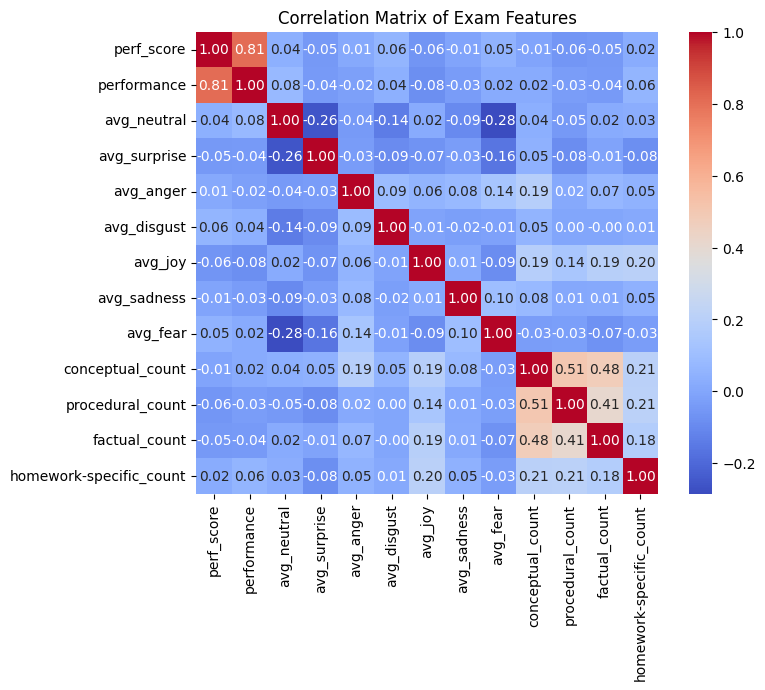

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for numeric columns
corr_matrix = exam_features_df[['used_chatbot_last_7_days','n_sessions_last_7_days','avg_length_conv','n_messages_last_7_days','total_duration_last_7_days',
                                'n_messages_day_before_exam','n_messages_on_exam_day', 'perf_score', 'performance', 'avg_neutral', 'avg_surprise', 'avg_anger',
                                'avg_disgust', 'avg_joy', 'avg_sadness', 'avg_fear']].corr()

# Compute correlation matrix for numeric columns
corr_matrix = exam_features_df[['perf_score', 'performance', 'avg_neutral', 'avg_surprise', 'avg_anger','avg_disgust', 'avg_joy', 'avg_sadness', 'avg_fear', 'conceptual_count', 'procedural_count',
       'factual_count', 'homework-specific_count']].corr()

# Optional: Visualize correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Exam Features')
plt.show()

## Model

We use a random forest classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#### We first try with all users including those that did not use the chatbot at all 

In [19]:
### We first try with all users including those that did not use the chatbot at all 

use_features = [
    'used_chatbot_last_7_days',
    'n_sessions_last_7_days',
    'avg_length_conv',
    'n_messages_last_7_days',
    'total_duration_last_7_days',
    'n_messages_day_before_exam',
    'n_messages_on_exam_day',

    'avg_neutral', 
    'avg_surprise', 
    'avg_anger',
    'avg_disgust', 
    'avg_joy', 
    'avg_sadness', 
    'avg_fear',

    'conceptual_count', 
    'procedural_count',
    'factual_count', 
    'homework-specific_count'
]

all_users = exam_features_df.copy()

# Step 3: Prepare features (X) and target (y)
X_intensity = all_users[use_features]
y_intensity = all_users['perf_score']  # Binary target: 1 if perf > 0, else 0

# Step 4: Split into train and test sets
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_intensity, y_intensity, test_size=0.2, random_state=42
)

# Step 5: Train the Random Forest Classifier
intensity_model = RandomForestClassifier(random_state=42)
intensity_model.fit(X_train_int, y_train_int)

# Step 6: Make predictions on the test set
y_pred = intensity_model.predict(X_test_int)

# Step 7: Evaluate model performance
accuracy = accuracy_score(y_test_int, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_int, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_int, y_pred))

Accuracy: 0.5744

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.84      0.66       481
           1       0.66      0.31      0.43       487

    accuracy                           0.57       968
   macro avg       0.60      0.58      0.54       968
weighted avg       0.60      0.57      0.54       968


Confusion Matrix:
[[403  78]
 [334 153]]



Feature Importances:
                       feature  importance
6       n_messages_on_exam_day    0.133561
4   total_duration_last_7_days    0.099815
2              avg_length_conv    0.073442
13                    avg_fear    0.072110
10                 avg_disgust    0.072004
12                 avg_sadness    0.070383
9                    avg_anger    0.070105
11                     avg_joy    0.068682
8                 avg_surprise    0.065772
7                  avg_neutral    0.061204
14            conceptual_count    0.042342
3       n_messages_last_7_days    0.039984
5   n_messages_day_before_exam    0.038555
16               factual_count    0.035481
1       n_sessions_last_7_days    0.026557
15            procedural_count    0.018764
17     homework-specific_count    0.010789
0     used_chatbot_last_7_days    0.000449


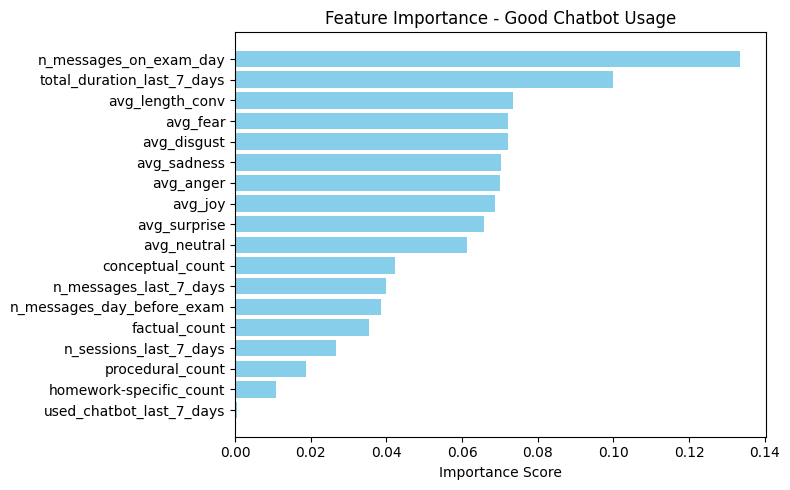

In [20]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = intensity_model.feature_importances_

# Create a DataFrame for better readability
importance_df = pd.DataFrame({
    'feature': use_features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Print ranked feature importances
print("\nFeature Importances:")
print(importance_df)

# Optional: plot
plt.figure(figsize=(8, 5))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest on top
plt.xlabel('Importance Score')
plt.title('Feature Importance - Good Chatbot Usage')
plt.tight_layout()
plt.show()

In [21]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Step 3: Prepare features (X) and target (y)
X_intensity = all_users[use_features]
y_intensity = all_users['perf_score']  # Binary target: 1 if perf > 0, else 0


# Use stratified CV to preserve class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Reuse your existing model
cv_scores = cross_val_score(intensity_model, X_intensity, y_intensity, cv=skf, scoring='accuracy')

print("Stratified CV Accuracy Scores:", cv_scores)
print(f"Average Stratified CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Stratified CV Accuracy Scores: [0.54752066 0.55946225 0.54912099 0.57083764 0.54912099]
Average Stratified CV Accuracy: 0.5552
Standard Deviation: 0.0089


#### Now we only concentrate on users of the chatbot to see if we can model what "good" usage is 

In [22]:
### Now we only concentrate on users of the chatbot to see if we can model what "good" usage is 

use_features = [
    'used_chatbot_last_7_days',
    'n_sessions_last_7_days',
    'avg_length_conv',
    'n_messages_last_7_days',
    'total_duration_last_7_days',
    'n_messages_day_before_exam',
    'n_messages_on_exam_day',

    'avg_neutral', 
    'avg_surprise', 
    'avg_anger',
    'avg_disgust', 
    'avg_joy', 
    'avg_sadness', 
    'avg_fear',

    'conceptual_count', 
    'procedural_count',
    'factual_count', 
    'homework-specific_count'
]


# Step 2: Subset data to users who used the chatbot
chatbot_users = exam_features_df[exam_features_df['used_chatbot_last_7_days'] == 1]

# Step 3: Prepare features (X) and target (y)
X_intensity = chatbot_users[use_features]
y_intensity = chatbot_users['perf_score']  # Binary target: 1 if perf > 0, else 0

# Step 4: Split into train and test sets
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_intensity, y_intensity, test_size=0.2, random_state=42
)

# Step 5: Train the Random Forest Classifier
intensity_model = RandomForestClassifier(random_state=42)
intensity_model.fit(X_train_int, y_train_int)

# Step 6: Make predictions on the test set
y_pred = intensity_model.predict(X_test_int)

# Step 7: Evaluate model performance
accuracy = accuracy_score(y_test_int, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_int, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_int, y_pred))

Accuracy: 0.6751

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.65      0.62       116
           1       0.73      0.70      0.71       161

    accuracy                           0.68       277
   macro avg       0.67      0.67      0.67       277
weighted avg       0.68      0.68      0.68       277


Confusion Matrix:
[[ 75  41]
 [ 49 112]]



Feature Importances:
                       feature  importance
4   total_duration_last_7_days    0.113763
9                    avg_anger    0.079595
11                     avg_joy    0.078917
2              avg_length_conv    0.077236
10                 avg_disgust    0.076976
13                    avg_fear    0.075092
8                 avg_surprise    0.072064
12                 avg_sadness    0.071592
7                  avg_neutral    0.068545
6       n_messages_on_exam_day    0.057994
5   n_messages_day_before_exam    0.047204
16               factual_count    0.044396
3       n_messages_last_7_days    0.042286
14            conceptual_count    0.039928
1       n_sessions_last_7_days    0.024817
15            procedural_count    0.018562
17     homework-specific_count    0.011034
0     used_chatbot_last_7_days    0.000000


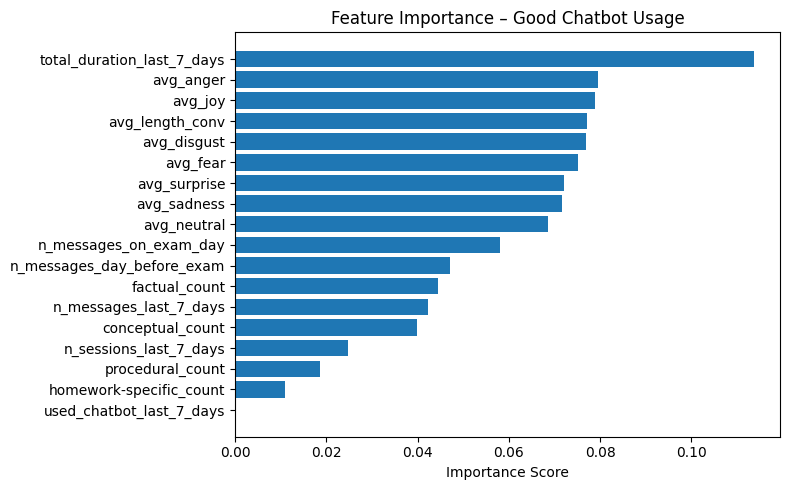

In [36]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = intensity_model.feature_importances_

# Create a DataFrame for better readability
importance_df = pd.DataFrame({
    'feature': use_features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Print ranked feature importances
print("\nFeature Importances:")
print(importance_df)


# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 5))

# Plot horizontal bar chart
ax.barh(importance_df['feature'], importance_df['importance'])
ax.invert_yaxis()  # Highest importance on top
ax.set_xlabel('Importance Score')
ax.set_title('Feature Importance – Good Chatbot Usage')

# Make backgrounds transparent
fig.patch.set_alpha(0.0)  # Transparent figure background
ax.patch.set_alpha(0.0)   # Transparent axes background

# Optional: save with transparency
# fig.savefig("feature_importance_transparent.png", dpi=300, bbox_inches='tight', transparent=True)

plt.tight_layout()
plt.show()


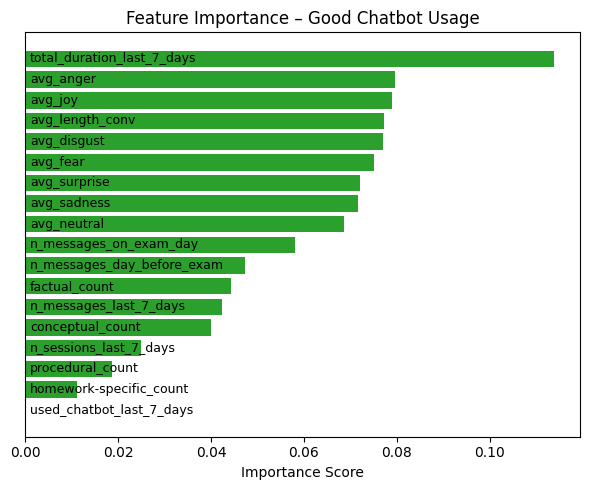

In [24]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 5))

# Plot horizontal bar chart in green
bars = ax.barh(
    importance_df['feature'],
    importance_df['importance'],
    color='tab:green'
)

ax.invert_yaxis()  # Highest importance on top
ax.set_xlabel('Importance Score')
ax.set_title('Feature Importance – Good Chatbot Usage')

# Annotate bars with feature names directly on them
for bar, feature in zip(bars, importance_df['feature']):
    ax.text(
        0.001 ,  # position slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,
        feature,
        va='center',
        ha='left',
        fontsize=9
    )

# Transparent backgrounds
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

ax.set_yticks([])

# Optional: save with transparency
# fig.savefig("feature_importance_transparent.png", dpi=300, bbox_inches='tight', transparent=True)

plt.tight_layout()
plt.show()

The y-axis shows the average predicted probability of the positive class (e.g., perf_score = 1) when you vary only this feature, holding all other features fixed.

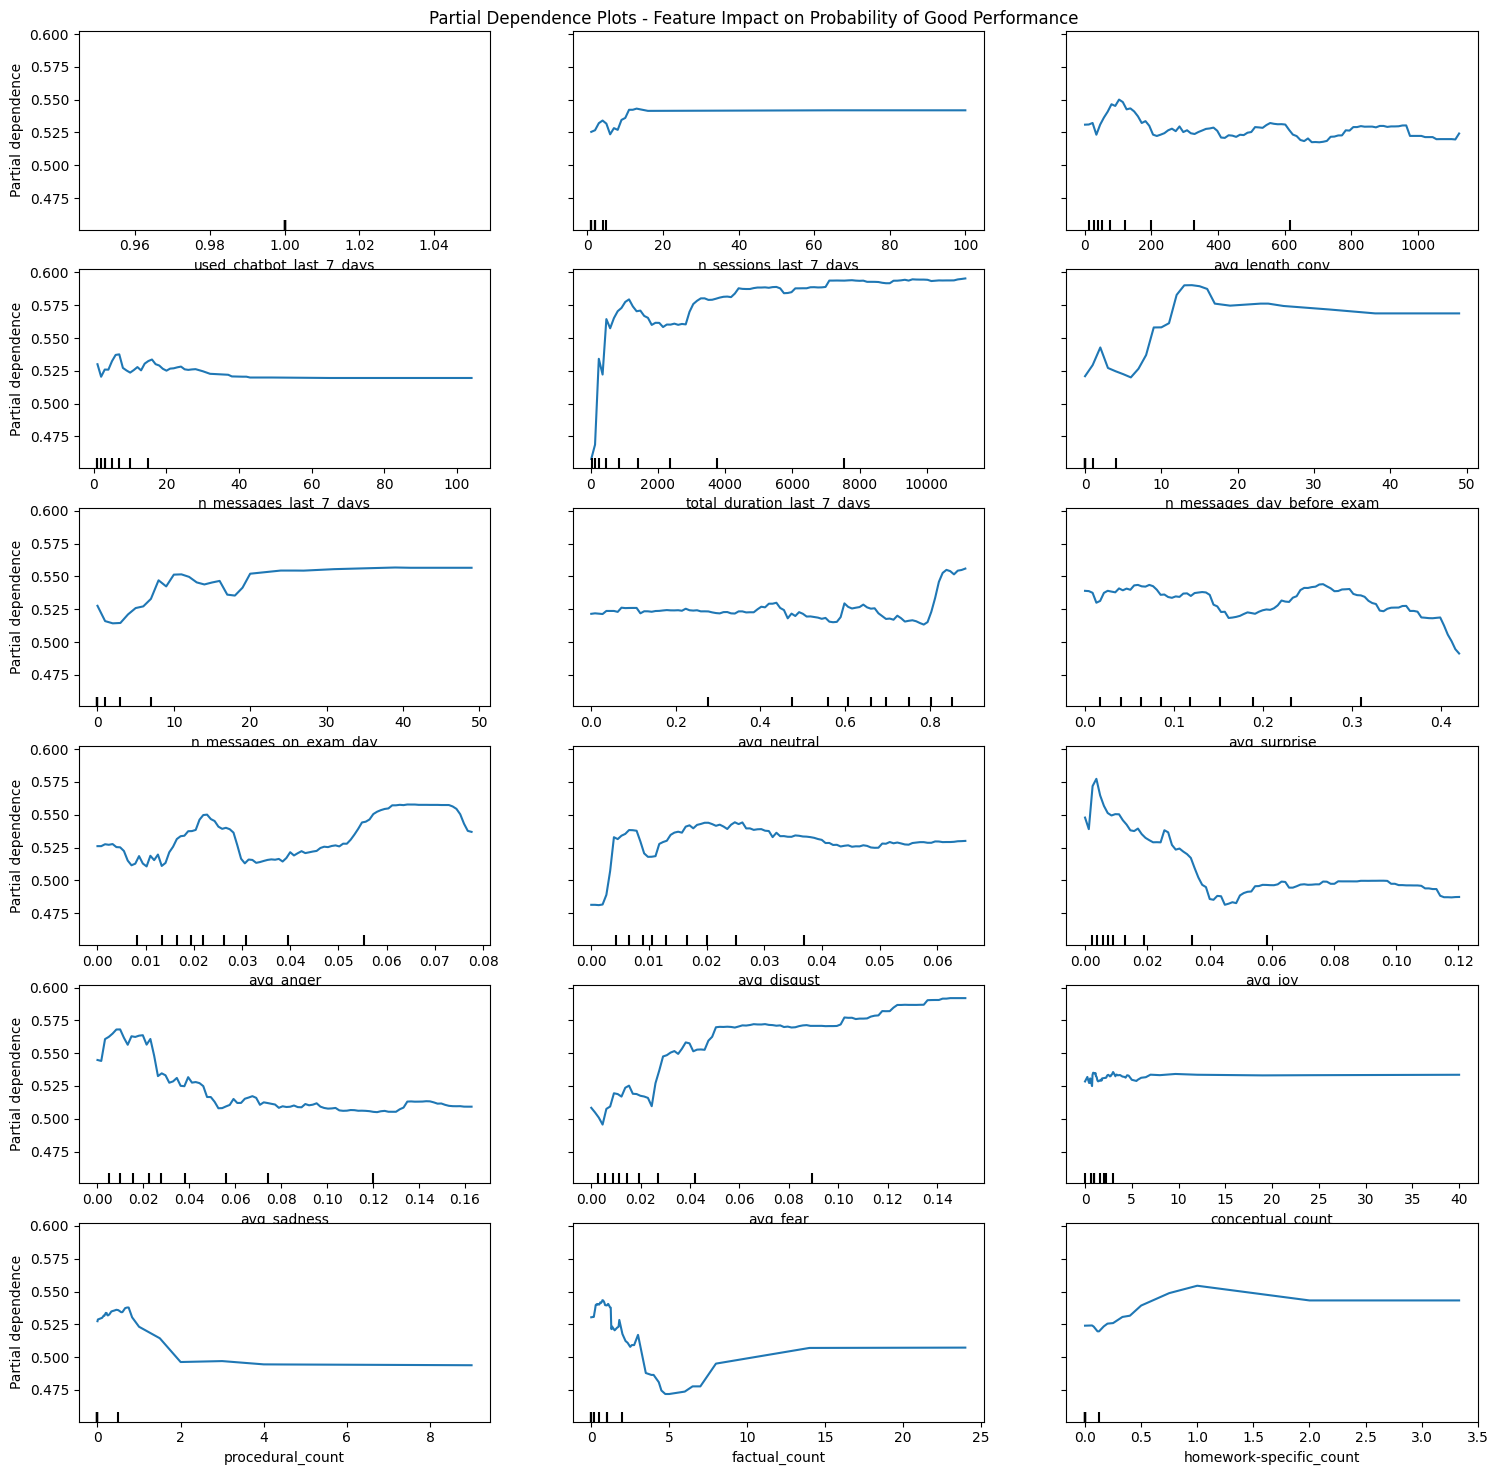

In [25]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
PartialDependenceDisplay.from_estimator(intensity_model, X_train_int, features=use_features, ax=ax)
plt.suptitle('Partial Dependence Plots - Feature Impact on Probability of Good Performance')
plt.tight_layout()
plt.show()

Available keys in pdp_result for feature used_chatbot_last_7_days: dict_keys(['grid_values', 'average'])
Available keys in pdp_result for feature n_sessions_last_7_days: dict_keys(['grid_values', 'average'])
Available keys in pdp_result for feature avg_length_conv: dict_keys(['grid_values', 'average'])
Available keys in pdp_result for feature n_messages_last_7_days: dict_keys(['grid_values', 'average'])
Available keys in pdp_result for feature total_duration_last_7_days: dict_keys(['grid_values', 'average'])
Available keys in pdp_result for feature n_messages_day_before_exam: dict_keys(['grid_values', 'average'])
Available keys in pdp_result for feature n_messages_on_exam_day: dict_keys(['grid_values', 'average'])
Available keys in pdp_result for feature avg_neutral: dict_keys(['grid_values', 'average'])
Available keys in pdp_result for feature avg_surprise: dict_keys(['grid_values', 'average'])
Available keys in pdp_result for feature avg_anger: dict_keys(['grid_values', 'average'])
A

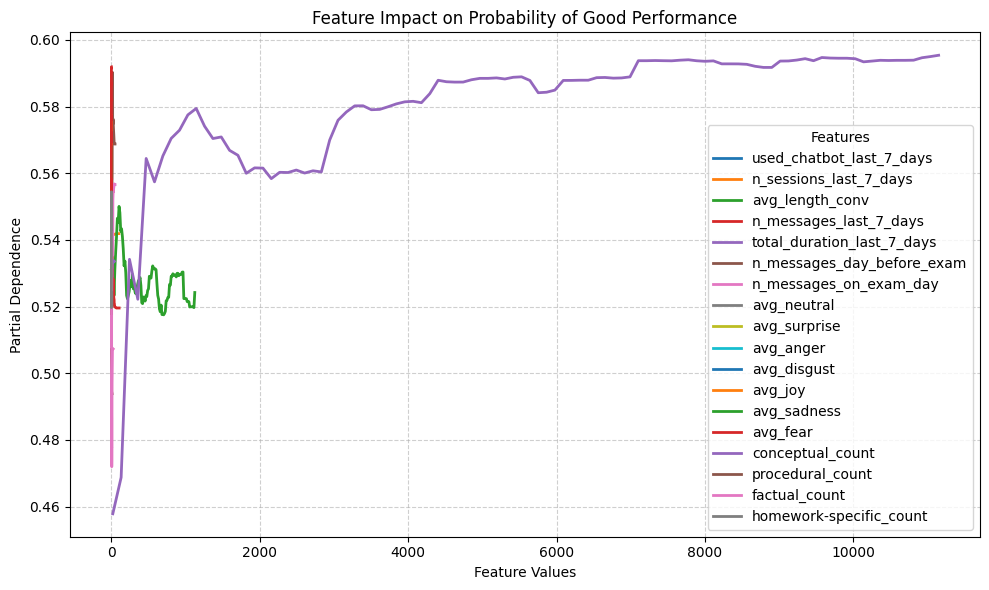

In [26]:
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
import numpy as np

# Create a single figure
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for different features
colors = plt.cm.tab10.colors

# Calculate and plot partial dependence for each feature separately
for i, feature in enumerate(use_features):
    # Calculate partial dependence
    pdp_result = partial_dependence(
        intensity_model, 
        X_train_int, 
        features=[feature]
    )
    
    # Check the structure of pdp_result to handle it correctly
    if isinstance(pdp_result, tuple):  # Older scikit-learn versions
        pdp_values = pdp_result[0][0]
        pdp_feature_values = pdp_result[1][0]
    else:  # Newer scikit-learn versions
        # Print keys to debug
        print(f"Available keys in pdp_result for feature {feature}: {pdp_result.keys()}")
        
        # Try different key patterns based on what's available
        if 'average' in pdp_result:
            pdp_values = pdp_result['average'][0]
            
            # Different possibilities for feature values
            if 'grid_values' in pdp_result:
                pdp_feature_values = pdp_result['grid_values'][0]
            elif 'mesh_values' in pdp_result:
                pdp_feature_values = pdp_result['mesh_values'][0]
            elif 'values' in pdp_result:
                pdp_feature_values = pdp_result['values'][0]
            else:
                # Create a range if no values are found
                pdp_feature_values = np.linspace(0, 1, len(pdp_values))
        else:
            # Last resort: try different structure
            pdp_values = pdp_result[0][0]
            pdp_feature_values = np.linspace(0, 1, len(pdp_values))
    
    # Plot on the same axes
    ax.plot(pdp_feature_values, pdp_values, color=colors[i % len(colors)], 
            linewidth=2, label=feature)

# Customize the plot
ax.set_xlabel('Feature Values')
ax.set_ylabel('Partial Dependence')
ax.set_title('Feature Impact on Probability of Good Performance')
ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
ax.legend(title='Features', loc='best')

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create lists to store results
features = use_features
positive_impact = []
negative_impact = []
impact_magnitude = []

# Iterate through each feature
for feature in features:
    # Get the original predictions
    original_preds = intensity_model.predict_proba(X_train_int)[:, 1]  # Probability of positive class
    
    # Create two modified datasets
    X_low = X_train_int.copy()
    X_high = X_train_int.copy()
    
    # Set feature to low value (10th percentile) - Fix for pandas
    low_value = X_train_int[feature].quantile(0.1)  # Using pandas quantile instead of np.percentile
    X_low[feature] = low_value
    
    # Set feature to high value (90th percentile)
    high_value = X_train_int[feature].quantile(0.9)  # Using pandas quantile
    X_high[feature] = high_value
    
    # Get predictions for modified datasets
    low_preds = intensity_model.predict_proba(X_low)[:, 1]
    high_preds = intensity_model.predict_proba(X_high)[:, 1]
    
    # Calculate the effect
    effect = np.mean(high_preds) - np.mean(low_preds)
    
    # Determine impact direction
    if effect > 0:
        positive_impact.append(feature)
        impact_magnitude.append(effect)
    else:
        negative_impact.append(feature)
        impact_magnitude.append(abs(effect))  # Store absolute value for plotting

# Print results
print("Features with positive impact on performance:")
for feature in positive_impact:
    print(f"- {feature}")

print("\nFeatures with negative impact on performance:")
for feature in negative_impact:
    print(f"- {feature}")


Features with positive impact on performance:
- n_sessions_last_7_days
- n_messages_last_7_days
- total_duration_last_7_days
- n_messages_day_before_exam
- n_messages_on_exam_day
- avg_neutral
- avg_surprise
- avg_anger
- avg_fear
- conceptual_count
- procedural_count

Features with negative impact on performance:
- used_chatbot_last_7_days
- avg_length_conv
- avg_disgust
- avg_joy
- avg_sadness
- factual_count
- homework-specific_count


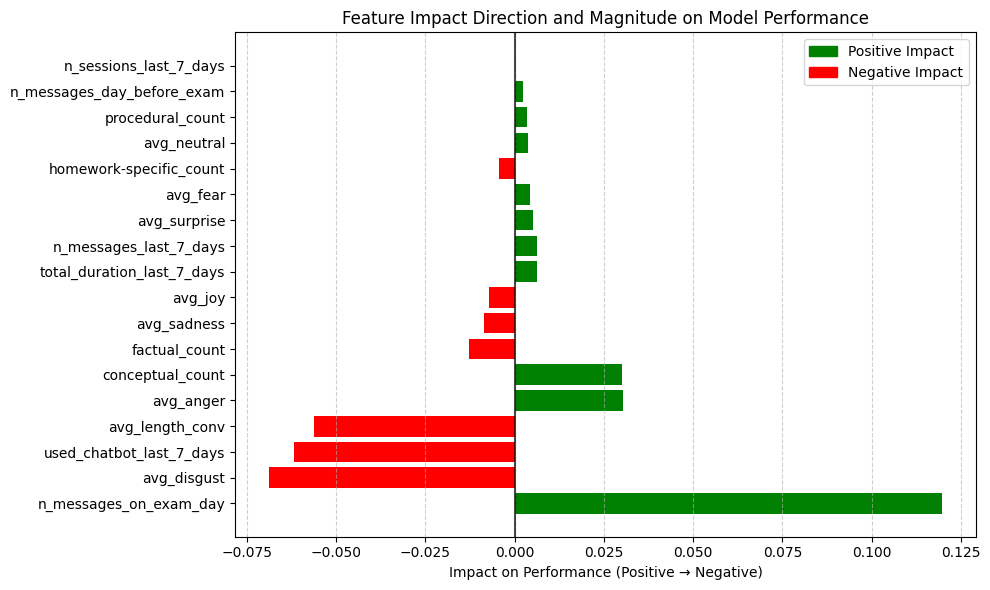

In [28]:
# Create a visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Combine all features with their impact magnitude and direction
all_features = positive_impact + negative_impact
all_magnitudes = impact_magnitude[:len(positive_impact)] + [-x for x in impact_magnitude[len(positive_impact):]]
feature_colors = ['green'] * len(positive_impact) + ['red'] * len(negative_impact)

# Create a DataFrame for sorting
impact_df = pd.DataFrame({
    'feature': all_features,
    'impact': all_magnitudes,
    'color': feature_colors
})

# Sort by absolute impact
impact_df = impact_df.reindex(impact_df['impact'].abs().sort_values(ascending=False).index)

# Plot horizontal bar chart
bars = ax.barh(impact_df['feature'], impact_df['impact'], color=impact_df['color'])

# Add a vertical line at x=0
ax.axvline(x=0, color='black', linestyle='-', alpha=0.7)

# Customize the plot
ax.set_xlabel('Impact on Performance (Positive → Negative)')
ax.set_title('Feature Impact Direction and Magnitude on Model Performance')
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Add a legend
import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='Positive Impact')
red_patch = mpatches.Patch(color='red', label='Negative Impact')
ax.legend(handles=[green_patch, red_patch], loc='upper right')

plt.tight_layout()
plt.show()

In [29]:
import shap

explainer = shap.Explainer(intensity_model, X_train_int)
shap_values = explainer(X_train_int)  # returns shap.Explanation object

/Users/fletchercollis/opt/anaconda3/envs/CS-421_ML4BD/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 2207/2210 [00:30<00:00]        

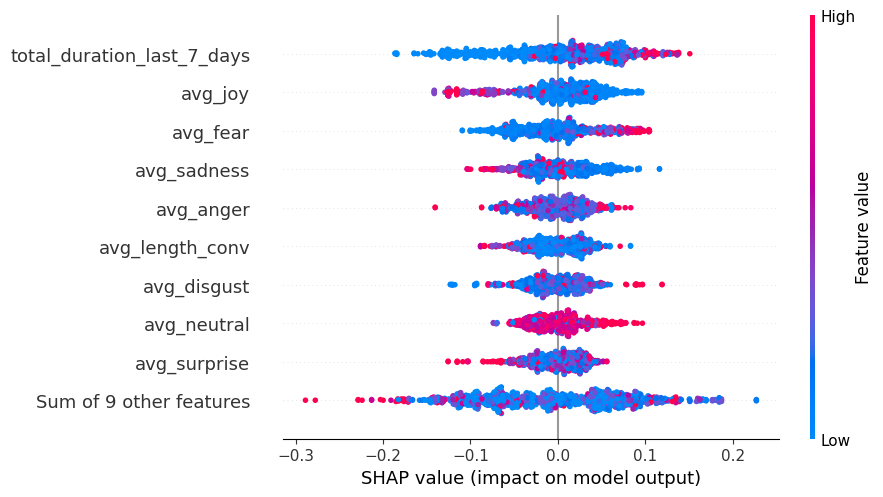

In [30]:
# Solution 1: Create a new Explanation object for a specific class
class_idx = 1  # Change to 0 for the first class

# Create a new explanation object for the selected class
class_explanation = shap.Explanation(
    values=shap_values.values[:, :, class_idx],
    base_values=shap_values.base_values[:, class_idx],
    data=shap_values.data,
    feature_names=shap_values.feature_names if hasattr(shap_values, 'feature_names') else None
)
shap.plots.beeswarm(class_explanation)

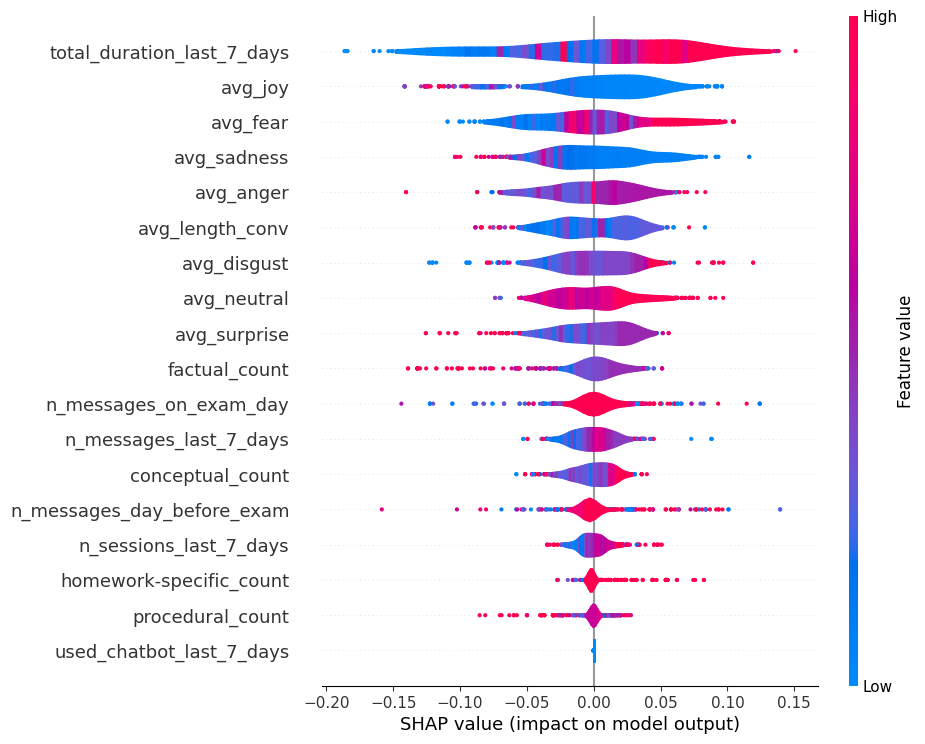

<Figure size 640x480 with 0 Axes>

In [43]:
shap.plots.violin(class_explanation)

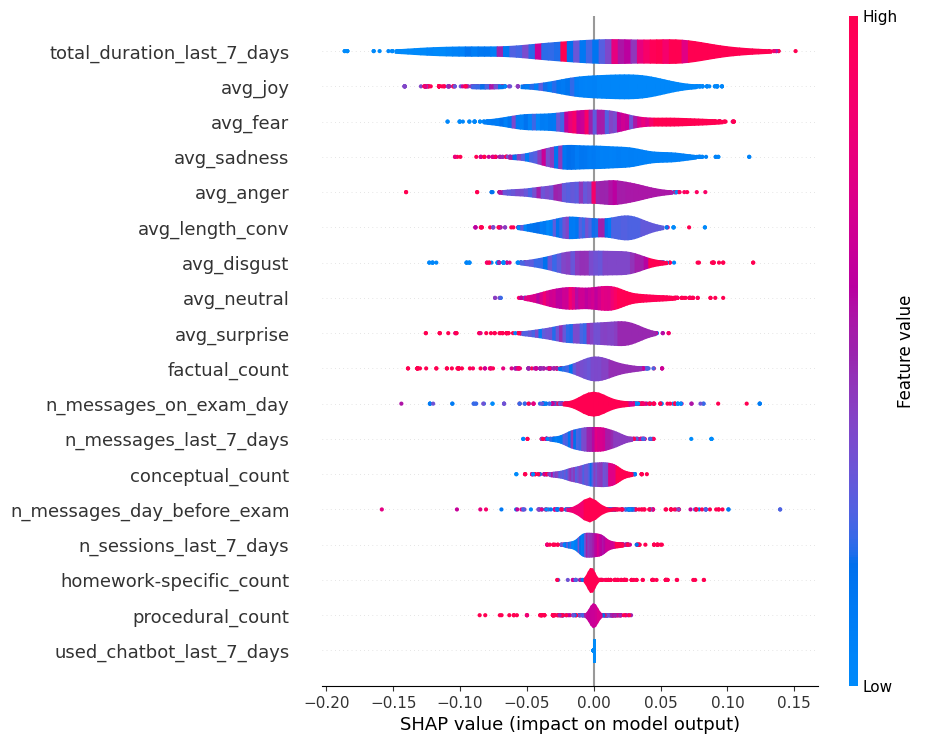

In [49]:
# Reset to default style
plt.style.use('default')

# Set transparent backgrounds
plt.rcParams['axes.facecolor'] = 'none'    # Axes background
plt.rcParams['figure.facecolor'] = 'none'  # Figure background

# Create figure with custom size
plt.figure(figsize=(8, 5))

# Generate the plot
shap.plots.violin(class_explanation)

# Optional: Save with transparent background
# plt.savefig("shap_violin.png", transparent=True, dpi=300)

# Show the plot
plt.show()

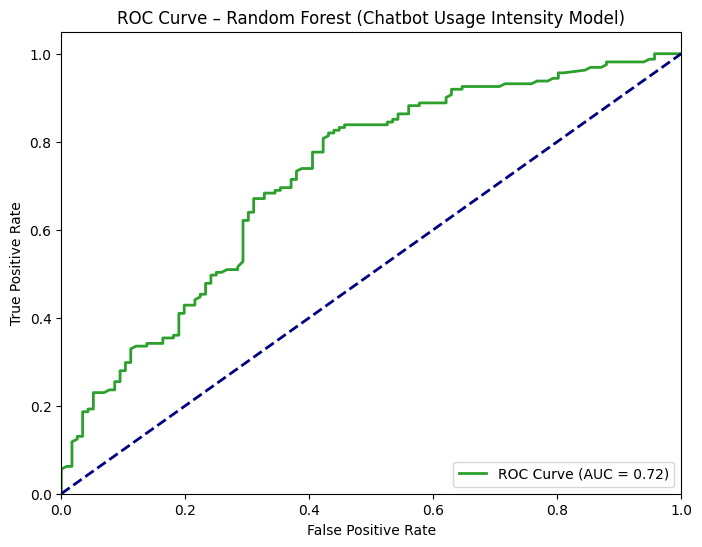

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 1: Predict probabilities for the positive class
y_proba = intensity_model.predict_proba(X_test_int)[:, 1]

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_int, y_proba)
roc_auc = auc(fpr, tpr)

# Step 3: Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROC
ax.plot(fpr, tpr, color='tab:green', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Axis limits and labels
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve – Random Forest (Chatbot Usage Intensity Model)')
ax.legend(loc='lower right')

# No grid, keep axis visible
ax.grid(False)

# Set figure and axes background to transparent
fig.patch.set_alpha(0.0)     # transparent figure background
ax.patch.set_alpha(0.0)      # transparent axes background

# Save as transparent PNG if desired
# fig.savefig("roc_curve_transparent.png", dpi=300, bbox_inches='tight', transparent=True)

plt.show()


In [38]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Step 3: Prepare features (X) and target (y)
X_intensity = chatbot_users[use_features]
y_intensity = chatbot_users['perf_score']  # Binary target: 1 if perf > 0, else 0


# Use stratified CV to preserve class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Reuse your existing model
cv_scores = cross_val_score(intensity_model, X_intensity, y_intensity, cv=skf, scoring='accuracy')

print("Stratified CV Accuracy Scores:", cv_scores)
print(f"Average Stratified CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Stratified CV Accuracy Scores: [0.66064982 0.6534296  0.67391304 0.63405797 0.63768116]
Average Stratified CV Accuracy: 0.6519
Standard Deviation: 0.0147


## Plots

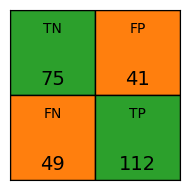

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Compute confusion matrix
cm = confusion_matrix(y_test_int, y_pred)

# Define position labels
labels = [['TN', 'FP'],
          ['FN', 'TP']]

# Color map: green for correct, red for errors
colors = [['tab:green', 'tab:orange'],  # TN, FP
          ['tab:orange', 'tab:green']]  # FN, TP

# Create figure and axis
fig, ax = plt.subplots(figsize=(2, 2))

# Draw colored rectangles and text
for i in range(2):
    for j in range(2):
        # Background box
        rect = patches.Rectangle(
            (j - 0.5, i - 0.5),
            1, 1,
            facecolor=colors[i][j],
            edgecolor='black',
            linewidth=1
        )
        ax.add_patch(rect)

        # Add TP/TN/FP/FN label
        ax.text(j, i - 0.2, labels[i][j], ha='center', va='bottom', fontsize=10)

        # Add number
        ax.text(j, i + 0.2, cm[i, j], ha='center', va='top', fontsize=14)

# Axes formatting
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)
ax.set_xticks([])
ax.set_yticks([])

# Transparent background
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

plt.tight_layout()
plt.show()

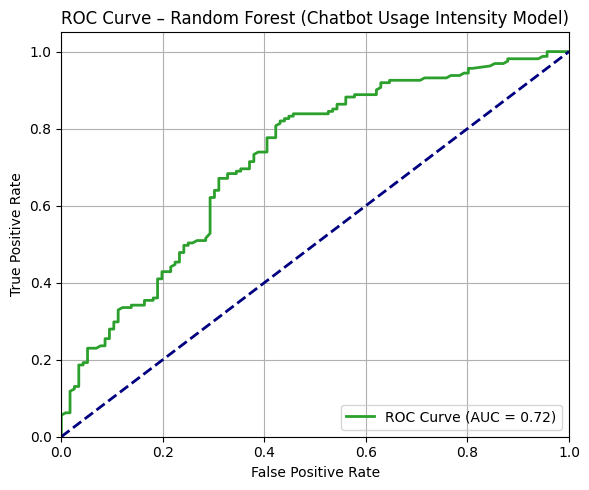

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Global style (already set, but safe to repeat)
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'sans-serif',
    'axes.titlesize': 12,
    'axes.labelsize': 10
})

# Predict probabilities
y_proba = intensity_model.predict_proba(X_test_int)[:, 1]

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test_int, y_proba)
roc_auc = auc(fpr, tpr)

# Create figure and axes
fig, ax = plt.subplots(figsize=(6, 5))  # match size

# Plot ROC curve
ax.plot(fpr, tpr, color='tab:green', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Axis labels and limits
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve – Random Forest (Chatbot Usage Intensity Model)')
ax.legend(loc='lower right', fontsize=10)

ax.grid(True)

# Transparent backgrounds
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

plt.tight_layout()
plt.show()